# Spike Challenge - Detector de Reggaetones

Manuel Larenas (manuel.a.larenas@gmail.com)

(Las preguntas del desafío se contestan al final de este análisis, posterior a las conclusiones)

## Creación del _dataset_
El _dataset_ recibido contiene atributos de canciones de Spotify divididas en dos archivos: el primero, canciones del género reggaeton, y el segundo, canciones de otros géneros musicales. El objetivo es desarrollar y evaluar un modelo de clasificación, que permita distinguir entre ambas clases en un conjunto de observaciones cuyo género musical es desconocido.

Las propiedades (columnas) de cada canción y el respectivo rango de posibles valores son:

1. popularity (no se informa rango)
2. danceability $[0, 1]$
3. energy $[0, 1]$
4. key (enteros entre 1 y 11)
5. loudness $[-60, 0]$
6. mode $\{0, 1\}$
7. speechiness $[0, 1]$
8. acousticness $[0, 1]$
9. instrumentalness $[0, 1]$
10. liveness $[0, 1]$
11. valence $[0, 1]$
12. tempo (entero en $[0, +\infty)$)
13. duration $[0,+\infty)$
14. time_signature (sólo segundo archivo) (entero entre 1 y 5)
15. id_new

La descripción cualitativa de cada una de estas variables se puede consultar en: https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

Comenzamos importando las librerías y archivos necesarios.

In [183]:
# Importing standard libraries
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
%matplotlib inline  

# Importing machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA

# Reading files
raw_reggaeton=pd.read_csv('data_reggaeton.csv', index_col='id_new')
raw_other=pd.read_csv('data_todotipo.csv', index_col='id_new')

# Transform duration [ms] -> [min]
raw_reggaeton['duration']=raw_reggaeton.duration/1000/60
raw_other['duration']=raw_other.duration/1000/60

Revisemos ahora la integridad de los DataFrame, tipos de datos y existencia de valores no numéricos.

In [184]:
# Checking data header and types for reggaeton
print raw_reggaeton.head()
print raw_reggaeton.info()
print raw_reggaeton.isnull().sum()

        Unnamed: 0  popularity  danceability  energy  key  loudness  mode  \
id_new                                                                      
1                1          68         0.826   0.704    9    -7.527     1   
2                2          61         0.641   0.693    8    -7.327     1   
3                3          67         0.771   0.815    1    -5.423     0   
4                4          63         0.743   0.787    1    -5.402     1   
5                5          63         0.876   0.692   10    -6.429     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
id_new                                                                   
1            0.1170        0.1890          0.000048    0.0617    0.741   
2            0.1630        0.0169          0.000000    0.2190    0.899   
3            0.0719        0.1610          0.000020    0.1890    0.524   
4            0.2620        0.0352          0.000000    0.0732    0.719   
5            0.1

In [185]:
# Checking data header and types for other genres
print raw_other.head()
print raw_other.info()
print raw_other.isnull().sum()

        Unnamed: 0  popularity  danceability  energy   key  loudness  mode  \
id_new                                                                       
71               1        68.0         0.650   0.884   1.0    -3.557   1.0   
72               2        59.0         0.588   0.623  11.0    -8.027   0.0   
73               3        61.0         0.577   0.880   6.0    -2.916   1.0   
74               4        60.0         0.795   0.724  11.0    -6.532   0.0   
75               5        62.0         0.557   0.703   8.0    -2.062   0.0   

        speechiness  acousticness  instrumentalness  liveness  valence  \
id_new                                                                   
71           0.0326      0.048200          0.154000    0.1350    0.377   
72           0.0304      0.000288          0.451000    0.1840    0.169   
73           0.0357      0.335000          0.896000    0.1430    0.259   
74           0.0861      0.404000          0.000002    0.3740    0.445   
75       

Algunas observaciones:
    
1. La columna 0 ('unnamed') debe ser removida en ambos DataFrames.
2. Dado que _time signature_ sólo está en el segundo archivo (no reggaetones), esta columna no es útil para clasificación. Debe ser removida.
3. El segundo archivo tiene 8 elementos _null_. Dado que estos representan menos del 0.4% de los datos, pueden ser removidos.
4. El número de observaciones del género reggaeton son muy inferiores (70 vs 2222), por lo que este problema de clasificación es claramente __desbalanceado__. Veremos más adelante como lidiar con esta dificultad.
    
Generamos una columna reggaeton para cada archivo, que toma valores 0 y 1. Por último, concatenamos ambos DataFrames en un solo _dataset_.

In [186]:
#Cleaning data
raw_reggaeton.drop(raw_reggaeton.columns[0], axis=1, inplace=True)

raw_other.drop(raw_other.columns[0], axis=1, inplace=True)
raw_other.drop('time_signature', axis=1, inplace=True)
raw_other.dropna(inplace=True)   

# Final data
data_reggaeton=raw_reggaeton
data_other=raw_other

# Labeling observations
data_reggaeton['reggaeton']=1
data_other['reggaeton']=0

# Merging data
dataset=pd.concat([data_reggaeton, data_other])

## Análisis exploratorio

La variable _mode_ es categórica. El gráfico inferior muestra la distribución por género de cada uno de los modos musicales (mayor o menor). Se aprecia que no existen diferencias relevantes, por lo tanto, _mode_ no es una buena variable para clasificación.

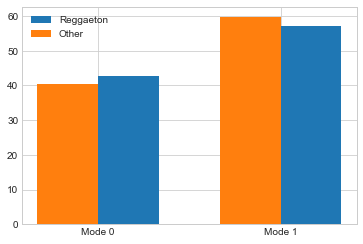

In [187]:
# Categorial features
plt.figure()
a00=dataset[dataset.reggaeton==0]['mode'].value_counts()[0]/len(dataset[dataset.reggaeton==0])*100
a01=dataset[dataset.reggaeton==0]['mode'].value_counts()[1]/len(dataset[dataset.reggaeton==0])*100
a10=dataset[dataset.reggaeton==1]['mode'].value_counts()[0]/len(dataset[dataset.reggaeton==1])*100
a11=dataset[dataset.reggaeton==1]['mode'].value_counts()[1]/len(dataset[dataset.reggaeton==1])*100
barWidth=0.2
a0=[a00, a01]
a1=[a10, a11]
r1=[0, 0.6]
r2=[x+barWidth for x in r1]
plt.bar(r2, a1, width=barWidth, label='Reggaeton')
plt.bar(r1, a0, width=barWidth, label='Other')
plt.xticks([r+barWidth/2 for r in r1], ['Mode 0', 'Mode 1'])
plt.legend()

Los 12 atributos restantes toman valores continuos (pseudo-continuo en el caso de _key_). Veremos gráficamente si existen diferencias significativas en cada una de estas variables de acuerdo al género musical.

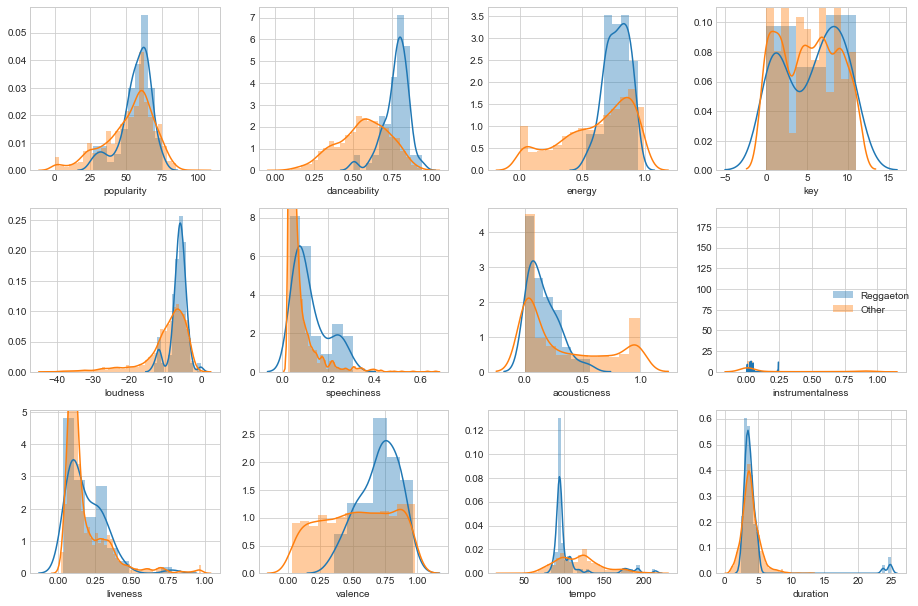

In [188]:
# Noncategorial features
noncateg_idx=[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]

fig=plt.figure(figsize=(6*2.13,4*2.13))
j=1
for i in noncateg_idx:
    plt.subplot(3,4,j)
    sns.distplot(dataset[dataset.reggaeton==1].iloc[:,i], label='Reggaeton')
    sns.distplot(dataset[dataset.reggaeton==0].iloc[:,i], label='Other')
    j+=1
fig.legend(loc=7)
fig.tight_layout()

Algunas observaciones: 

1. Existe una importante asimetría en la distribución de la mayoría de las variables. Es necesario normalizar los datos para mejorar el desempeño de algunos de los algoritmos de clasificación.
2. Los parámetros asociados al género reggaeton tienen distribuciones en general más estrechas de los datos, lo cual puede beneficiar el proceso de clasificación.
3. En primera instancia, las propiedades que podrían tener mayor relevancia en la clasificación son: _danceability_, _energy_, _loudness_, _valence_ y _tempo_.
4. Los atributos de distribución similar entre géneros son: _popularity_, _key_, _liveness_ y _duration_. Es posible que tengan una menor preponderancia en la clasificación.
5. _speechiness_, _acousticness_ e _instrumentalness_ no permiten distinguir a priori una relación relevante.
    
A continuación observamos la matriz de correlaciones entre los 13 atributos de las canciones del _dataset_ completo.

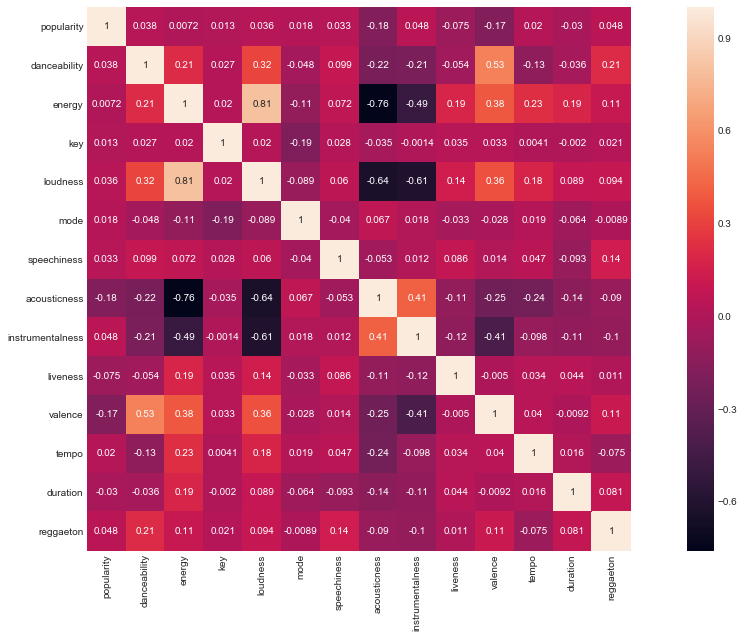

In [189]:
# Correlation matrix
corr_mat=dataset.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True)

De la matriz de correlaciones sólo es posible desprender que existe una correlación moderada y negativa entre _acousticness_ y _energy_, _acousticness_ y _loudness_ e _instrumentalness_ y _loudness_. La ausencia de fuertes correlaciones entre los atributos puede ser favorable para el desempeño de algunos algoritmos (por ejemplo, Naive Bayes) que están basados en la hipótesis de independencia.

Por otro lado, no se observa una relación relevante entre el género reggaeton y cada uno de los 13 atributos. Esto indica que el modelo de clasificación debe incluir varias propiedades para lograr una predicción confiable. El PCA permite distinguir cuantas variables son necesarias para explicar la varianza en el género, lo cual veremos a continuación.

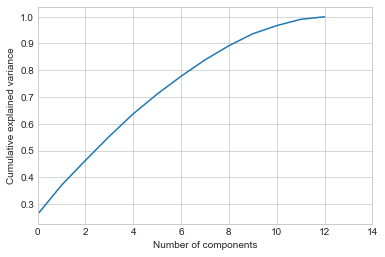

In [190]:
# Separate atributes and class
X=dataset.iloc[:, :-1].values
Y=dataset.iloc[:, -1].values

# StandardScaler
sc=StandardScaler()
X_pca=sc.fit_transform(X)

# PCA
pca=PCA().fit(X_pca)

# Explained variance plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)

El gráfico anterior revela que para explicar un 90% de la varianza observada, es necesario considerar 8 de los atributos. Si fuera necesario más adelante mejorar los tiempos de ejecución de los algortimos, será posible proyectar en las componentes principales de acuerdo a algún criterio de corte apropiado.

# Comparación de algoritmos de clasificación

Antes de analizar distintos tipos de modelos de clasificación, se dividirá el _dataset_ en observaciones de entrenamiento (80%) y test (20%), para luego estandarizar los datos en base al conjunto de entrenamiento.

In [191]:
# Train/test split
seed=77
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=seed)
sc=StandardScaler().fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

Los métodos de clasificación a evaluar a continuación son los más utilizados actualmente en aplicaciones prácticas, con ventajas y desventajas propias de cada formulación. Se excluirá del análisis el algortimo _XGBoost_, cuyo desempeño es muy competitivo pero requiere una amplia afinación de parámetros. Otros algoritmos más avanzados pueden emplearse en un trabajo posterior para profundizar en este desafío.

In [192]:
# Classification models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM1', SVC(kernel="linear", C=0.025)))
models.append(('SVM2', SVC(gamma=2, C=1)))

El primer estudio comparativo a realizar está basado en las curvas de aprendizaje para cada método. De esta forma se puede entender cómo evoluciona el desempeño separadamente para el conjunto de entrenamiento y el conjunto test, a medida que se incorporan las observaciones. La siguiente función genera dicho gráfico en base a la evaluación de área bajo la curva (AUC) ROC, la cual es más representativa del desempeño real de un método para clases desbalanceadas como en este caso. El indicador comúnmente empleado, _accuracy_, no es apropiado en presencia de clases desbalanceadas.

Notar que es necesario utilizar _StratifiedKFold_ para la generación de las _folds_ en los gráficos de más abajo. De esta manera se mantiene equilibrada la presencia de clases dado el desbalance de nuestro _dataset_.

In [193]:
def plot_learning_curve(estimator, title, X, Y, cv, train_sizes=np.linspace(.2, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.title(title)
    plt.ylim([0.6, 1.01])
    plt.xlabel('Training examples')
    plt.ylabel('AUC Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV score")
    plt.legend(loc=4)

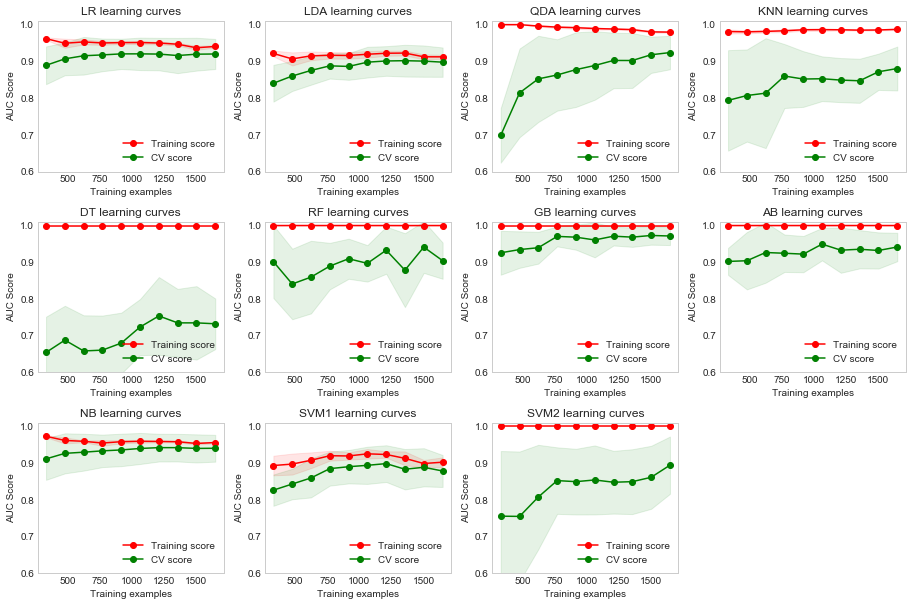

In [194]:
# Plotting learning curves
fig=plt.figure(figsize=(6*2.13,4*2.13))
i=1
kfold = StratifiedKFold(n_splits=10)
for name, classifier in models:
    plt.subplot(3,4,i)
    plot_learning_curve(classifier, name+' learning curves', X_train, Y_train, cv=kfold) 
    i+=1
fig.tight_layout()

Del gráfico anterior se pueden desprender las siguientes observaciones:

1. La gran mayoría de las curvas son ascendentes, con rendimientos muy diversos entre métodos.
2. Los algortimos _DT_, _RF_, _GB_, _AB_ y _SVM2_ evidencian curvas de entrenamiento casi constantes de valor igual a 1. Esto muestra que el riesgo de **overfitting** está presente y debe ser considerado.
3. Los métodos _QDA_, _GB_, _AB_ y _SVM2_ tienen el potencial de mejorar su desempeño mediante la utilización de un conjunto de entrenamiento más grande. De esta forma se podría ganar más precisión del algoritmo.
4. Los métodos cuyos resultados son más realistas y que, preliminarmente, podrían ser los más apropiados para ejecutar el presente análisis, son _LR_ y _NB_.

Complementemos este estudio con curvas ROC promediadas entre _folds_ para cada uno de los métodos anteriores (exceptuando SVC, para los cuales la interpretación probabilística de los resultados no es directa).

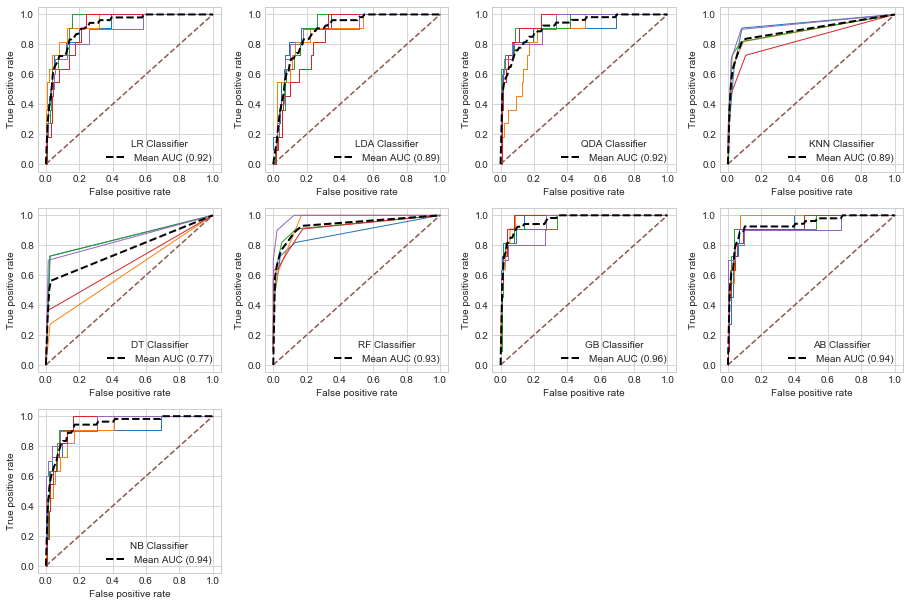

In [195]:
# Plotting ROC curves
kfold=StratifiedKFold(n_splits=5, random_state=99)
mean_fpr = np.linspace(0, 1, 100)
fig=plt.figure(figsize=(6*2.13,4*2.13))
i=0
j=1
for name, classifier in models[:9]:
    tprs = []
    aucs = []
    plt.subplot(3,4,j)
    for train, test in kfold.split(X_train, Y_train):
        probas=classifier.fit(X_train[train], Y_train[train]).predict_proba(X_train[test])
        fpr, tpr, thresholds = roc_curve(Y_train[test], probas[:,1], pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr)) 
        tprs[-1][0]=0.0
        roc_auc=auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1)
        i+=1

    plt.plot([0,1], [0,1], linestyle='--')
    mean_tpr=np.mean(tprs, axis=0)
    mean_tpr[-1]=1.0
    mean_auc=auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean AUC (%0.2f)' %mean_auc, lw=2)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(title=name+' Classifier')
    j+=1
fig.tight_layout()

En el gráfico anterior se aprecian resultados consistentes con las curvas de entrenamiento. En conjunto, permiten concluir que buenos candidatos a métodos para explorar más en profundidad son _LR_, _GB_, _AB_ y _NB_.

Para terminar esta sección, démos una mirada a la dispersión de los resultados predictivos de cada método para un importante número de _folds_. Nuevamente, la métrica empleada será AUC debido al desbalance de clases en los datos.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LR: 0.912637 (0.085102)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
LDA: 0.890721 (0.072366)
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
QDA: 0.919256 (0.076103)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNN: 0.894695 (0.090910)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
        

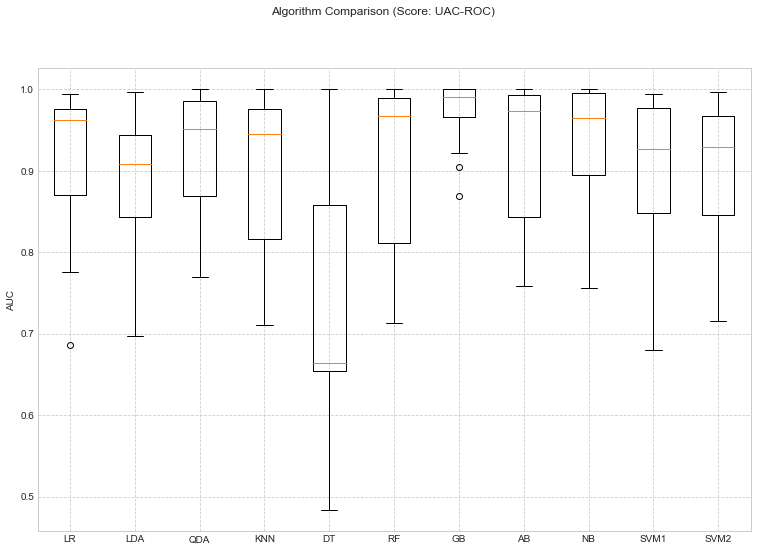

In [196]:
# Calculating AUC scores for different methods and 20 folds
seed=44
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    print model
    kfold = StratifiedKFold(n_splits=20, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot comparing methods
fig, ax = plt.subplots(figsize=(6*2.13,4*2.13))
#plt.axhline(0.9685, alpha=0.5)
fig.suptitle('Algorithm Comparison (Score: UAC-ROC)')
plt.boxplot(results)
plt.grid(linestyle='dashed')
ax.set_xticklabels(names)
plt.ylabel('AUC')
plt.show()

Notemos que los 4 modelos escogidos (_LR_, _GB_, _AB_ y _NB_) muestran un desempeño favorable también en este caso. Se convierten entonces en alternativas convenientes para generar un modelo ensamblado que decida según alguna metodología de votación. Antes de ello, y para mejorar cada modelo separadamente, se implementará un proceso de _GridSearch_ para determinar los hiperparámetros óptimos.

Cabe hacer notar que la amenaza de overfitting puede aún estar presente a pesar del ensamblaje de modelos. Un ajuste fino en este aspecto puede profundizarse en una etapa posterior de este trabajo.



In [197]:
seed=33
score='roc_auc'

# New train/test split and scaling
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.35, random_state=seed)
sc=StandardScaler().fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

# Parameters for GridSearch
parameters_LR={'C': list(np.linspace(0.1, 100, 100))}
parameters_GB={'n_estimators': list(np.linspace(2,1000,10).astype(int)), 'learning_rate' : list(np.linspace(0.1,0.3,3)),\
               'max_depth': list(np.linspace(1,5,5).astype(int)), 'max_features': list(np.linspace(1,3,3).astype(int))}
parameters_AB={'n_estimators': list(np.linspace(2,1000,20).astype(int)), 'learning_rate' : list(np.linspace(0.1,1,20))}

# Determining optimal hyperparameters
classifier_LR=LogisticRegression(random_state=seed, class_weight='balanced')
gs_LR=GridSearchCV(classifier_LR, parameters_LR, n_jobs=-1, verbose=1, cv=10, scoring=score)
gs_LR=gs_LR.fit(X_train,Y_train)
gs_LR_bestParam = gs_LR.best_params_
gs_LR_bestScore = gs_LR.best_score_
print 'LR results:'
print gs_LR_bestParam
print gs_LR_bestScore

classifier_GB=GradientBoostingClassifier(random_state=seed)
gs_GB=GridSearchCV(classifier_GB, parameters_GB, n_jobs=-1, verbose=1, cv=10, scoring=score)
gs_GB=gs_GB.fit(X_train,Y_train)
gs_GB_bestParam = gs_GB.best_params_
gs_GB_bestScore = gs_GB.best_score_
print 'GB results:'
print gs_GB_bestParam
print gs_GB_bestScore

classifier_AB=AdaBoostClassifier(random_state=seed)
gs_AB=GridSearchCV(classifier_AB, parameters_AB, n_jobs=-1, verbose=1, cv=10, scoring=score)
gs_AB=gs_AB.fit(X_train,Y_train)
gs_AB_bestParam = gs_AB.best_params_
gs_AB_bestScore = gs_AB.best_score_
print 'AB results:'
print gs_AB_bestParam
print gs_AB_bestScore

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 795 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


LR results:
{'C': 1.1090909090909091}
0.912669699122
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  2.4min finished


GB results:
{'max_features': 1, 'n_estimators': 556, 'learning_rate': 0.20000000000000001, 'max_depth': 2}
0.977863431447
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 15.5min finished


AB results:
{'n_estimators': 632, 'learning_rate': 1.0}
0.977095700527


# Construcción del modelo

Con los parámetros óptimos identificados en la sección anterior, definimos entonces los modelos individuales y luego el modelo ensamblado final. Dado que se trabajó separadamente en cada algoritmo para mejorar su calibración, se utilizará una votación tipo _soft_. Por último, un análisis preliminar de los resultados del modelo final indica que asignar un peso mayor al algortimo _NB_ puede conducir a balancear las _misclassifications_.

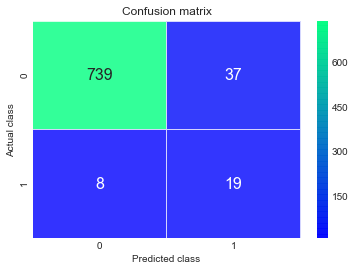

Ensamble score AUC: 0.8280


In [198]:
# Defining optimal models
LR_best=LogisticRegression(random_state=seed, **gs_LR_bestParam)
GB_best=GradientBoostingClassifier(random_state=seed, **gs_GB_bestParam)
AB_best=AdaBoostClassifier(random_state=seed, **gs_AB_bestParam)
NB_best=GaussianNB()

# Ensamble model
vc=VotingClassifier(estimators=[('LR', LR_best), ('GB', GB_best), ('AB', AB_best), ('NB', NB_best)],\
                                voting='soft', weights=[1, 1, 1, 3])

# Calculating confusion matrix
vc.fit(X_train, Y_train)
Y_pred=vc.predict(X_test)
conf_matrix=confusion_matrix(Y_test, Y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, cmap='winter', annot_kws={'size': 16}, alpha=0.8)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion matrix')
plt.show()
print 'Ensamble score AUC: %0.4f' %roc_auc_score(Y_test, Y_pred)

El AUC _score_ del modelo ensamblado es de **82,8%**. 

Algunos indicadores adicionales (P=1, N=0):

    ERR=(FP+FN)/(FP+FN+TP+TN)=0.0560
    ACC=1-ERR=0.9440

Para problemas de clases desbalanceadas son también relevantes las siguientes métricas:

    True positive rate:  TPR=TP/(FN+TP)=0.7037
    False positive rate: FPR=FP/(FP+TN)=0.0477

    Precision: PRE=TP/(TP+FP)=0.3393
    Recall: REC=TPR=0.7037
    F1-score: F1=2*(PRE*REC)/(PRE+REC)=0.4578

Por último, utilizamos este modelo ensamblado para la predicción del género musical en un nuevo set de datos, cuya clasificación real es desconocida.

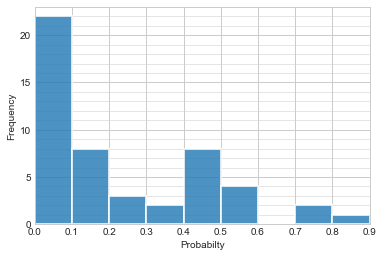

In [199]:
# Reading test set
raw_new=pd.read_csv('data_test.csv')
data_new=raw_new.copy().set_index('id_new')

# Transform duration [ms] -> [min]
data_new['duration']=data_new.duration/1000/60

# Cleaning data
data_new.drop(data_new.columns[0], axis=1, inplace=True)
data_new.drop('time_signature', axis=1, inplace=True)

# Prediction and probablity
X_new=sc.transform(data_new)
Y_new=vc.predict(X_new)
Y_proba=vc.predict_proba(X_new)

# Histogram
import matplotlib as mpl
fig, ax= plt.subplots()
#sns.set_style('whitegrid')
sns.distplot(Y_proba[:,1], bins=np.linspace(0,0.9,10), kde=False, hist_kws=dict(edgecolor="w", linewidth=2,alpha=0.8) )
plt.xlim([0,0.9])
plt.ylim(ymax=23)
plt.xlabel('Probabilty')
plt.ylabel('Frequency')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='minor', linewidth=0.5)
ax.grid(which='major', linewidth=1.0)
plt.show()

# Saving into file
raw_new['marca_reggaeton']=Y_new
raw_new['probabilidad_reggaeton']=Y_proba[:,1]
raw_new.to_csv('data_test_output.csv', index=False)

En resultado del modelo predictivo sobre el nuevo _dataset_ clasifica un total de 7 canciones como reggaeton. La distribución de probabilidades resultantes se encuentra en el histograma superior. Ambos atributos se agregan como columnas adicionales al _dataset_ final, el cual queda consolidado en el archivo ´data_test_output.csv´.

# Conclusiones

**Sobre el dataset**
1. A pesar que la cantidad de observaciones (canciones) fue suficiente para construir y evaluar un modelo clasificador, las curvas de aprendizaje mostraron que incorporar más entradas puede ser beneficioso para mejorar la calidad del modelo.
2. Incoporar atributos adicionales, tales como año de producción, título e incluso letras de las canciones, pueden contribuir notablemente a mejorar el desempeño de  un clasificador. Más aún, identificar perfiles de personas con gustos similares, o hacer _web scrapping_ en base a títulos de la canción, puede añadir dimensiones muy enriquecedoras para generar un modelo más avanzado.
3. El desbalance en el número de observaciones por cada clase genera dificultades adicionales al problema, las cuales pueden ser mitigadas mediante una metodología apropiada. Utilizar _stratified folds_ y evaluar desempeño mediante AUC (no _accuracy_) son algunas de las herramientas que se emplearon en este análisis, sin embargo, es posible incorporar otras estrategias adicionales como _subsampling_, _oversampling_, _SMOTE_, etc.
4. El gráfico comparativo de la distribución de atributos entre clases evidencia diferencias útiles para la clasificación. En este trabajo no se descartó ninguno de los atributos de las canciones, lo cual se puede utilizar en la práctica para controlar el _overfitting_ y reducir la complejidad del cálculo, entre otros beneficios. EL PCA indica la contribución del número de componentes principales, por lo que se propone para un trabajo posterior analizar en detalle los atributos y su contribución al desempeño del rendimiento del modelo para remover y/o construir _features_ que mejoren los resultados.

**Sobre los algoritmos de clasificación**
1. En este desafío se compararon 11 métodos disponibles en la librería _sklearn_. Otros métodos de clasificación, como XGBoost y _neural networks_, pueden otorgar resultados muy competitivos, por lo cual se recomienda profundizar en éstos y otros métodos más avanzados.
2. Las curvas de aprendizaje, ROC y _boxplot_ presentadas, permiten establecer candidatos apropiados para modelos de clasificación. El riesgo de _overfitting_ se hace manifiesto en estos diagramas por lo que es importante tomar consideraciones apropiadas.
3. Se recomienda analizar nuevamente el desempeño comparativo entre los modelos, esta vez con los parámetros óptimos entregados por _GridSearch_ para ratificar esta elección.

**Sobre el modelo emsamblado**
1. El ensamblaje de algoritmos en una metodología utilizada comúnmente en la práctica para corregir algunas desventajas o tendencias indeseadas propias de cada método. Para garantizar la elección apropiada de los pesos en el _VotingClassifier_, es necesario profundizar mediante _GridSearch_ o alguna estrategia similar. En el presente caso, se establecieron pesos que maximizaran el AUC sobre el conjunto de prueba como una aproximación preliminar.
2. El resultado obtenido del modelo ensamblado sobre el conjunto de prueba es aceptable en términos de _misclassifications_. 
Naturalmente el _accuracy_ del modelo propuesto es menor que la solución trivial (97%), puesto que el enfoque está puesto en el AUC.

**Sobre los resultados en el nuevo set de datos**
1. El resultado de la predicción arroja 7 positivos en un total de 50 observaciones (14%), lo cual está muy por sobre el conjunto usado para entrenar el modelo (3%). Esto puede ser indicativo de que el nuevo _dataset_ no tiene la misma distribución de géneros que el conjunto de entrenamiento.
2. Se debe tener presente que la columna de probabilidades entregada por el método _predict proba_ no representa propiamente probabilidades en el sentido matemático, más bien, son indicativos de la frecuencia de resultados prescritos por cada clase.
3. Por defecto, el modelo propuesto arroja el resultado positivo cuando la probabilidad asociada es mayor a 0,5. Este _threshold_ puede ajustarse a voluntad en base a la curva ROC asociada al algoritmo y a la importancia relativa entre tipo de _misclassification_ que se establezca. En otras palabras, preferencias como: "me gusta tanto el reggaeton, que no me importaría que el sistema me recomendara canciones de otro género con tal de que no se me pase alguna de mi gusto", o bien, "odio tanto el reggaeton, que no me importaría dejar de escuchar otras canciones con tal de que no me aparezca un reggaeton", se pueden traducir en criterios para elegir puntos dentro de la curva ROC y, de esta manera, establecer el _threshold_ adecuado a la preferencia del usuario para controlar el número de positivos asignado por el algoritmo.

# Respuestas a las preguntas del desafío

1. Propiedades de los atributos (cantidad, _missing values_, distribución comparativa entre géneros, etc) fueron discutidas en el cuerpo del trabajo.
2. Hecho.
3. Hecho.
4. Discutido en las conclusiones.
5. Discutido en las conclusiones.
